In [68]:
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from utils import histogram, abs_err, gmae
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

num_gpus = 4
epsilon = 4e-4
saturation_th = 0.05
superscript = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")
collectives = ['all_to_all', 'all_to_allv', 'all_reduce', 'all_gather', 'all_gather_base', 'reduce', 'reduce_scatter']
mul_factor_funcs = {
    'all_to_all': lambda n: (n-1) / n,
    'all_to_allv': lambda n: (n-1) / n,
    'all_reduce': lambda n: 2 * (n-1) / n,
    'all_gather': lambda n: (n-1) / n,
    'all_gather_base': lambda n: (n-1) / n,
    'reduce': lambda n: 1,
    'reduce_scatter': lambda n: (n-1) / n
}

In [69]:
num_of_collectives = len(collectives)
data = {}
for idx, collective in enumerate(collectives):
    data[collective] = {
        'size': [],
        'latency': [],
        'alg_bw': [],
        'bus_bw': []
    }
    filename = '../3rdparty/param/train/comms/pt/bench_results/{}_{}.txt'.format(collective, num_gpus)
    header_found = False
    with open(filename, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if re.search('COMMS-RES', line):
                if not header_found:
                    header_found = True
                    continue
                data[collective]['size'].append(int(line.split('\t')[2].lstrip('\t')))
                data[collective]['latency'].append(float(line.split('\t')[4].lstrip('\t')))
                data[collective]['alg_bw'].append(float(line.split('\t')[-2].rstrip('\n')) + epsilon)
                data[collective]['bus_bw'].append(float(line.split('\t')[-1].rstrip('\n')) + epsilon)
        data[collective]['size'] = np.array(data[collective]['size'])
        data[collective]['latency'] = np.array(data[collective]['latency'])
        data[collective]['alg_bw'] = np.array(data[collective]['alg_bw'])
        data[collective]['bus_bw'] = np.array(data[collective]['bus_bw'])

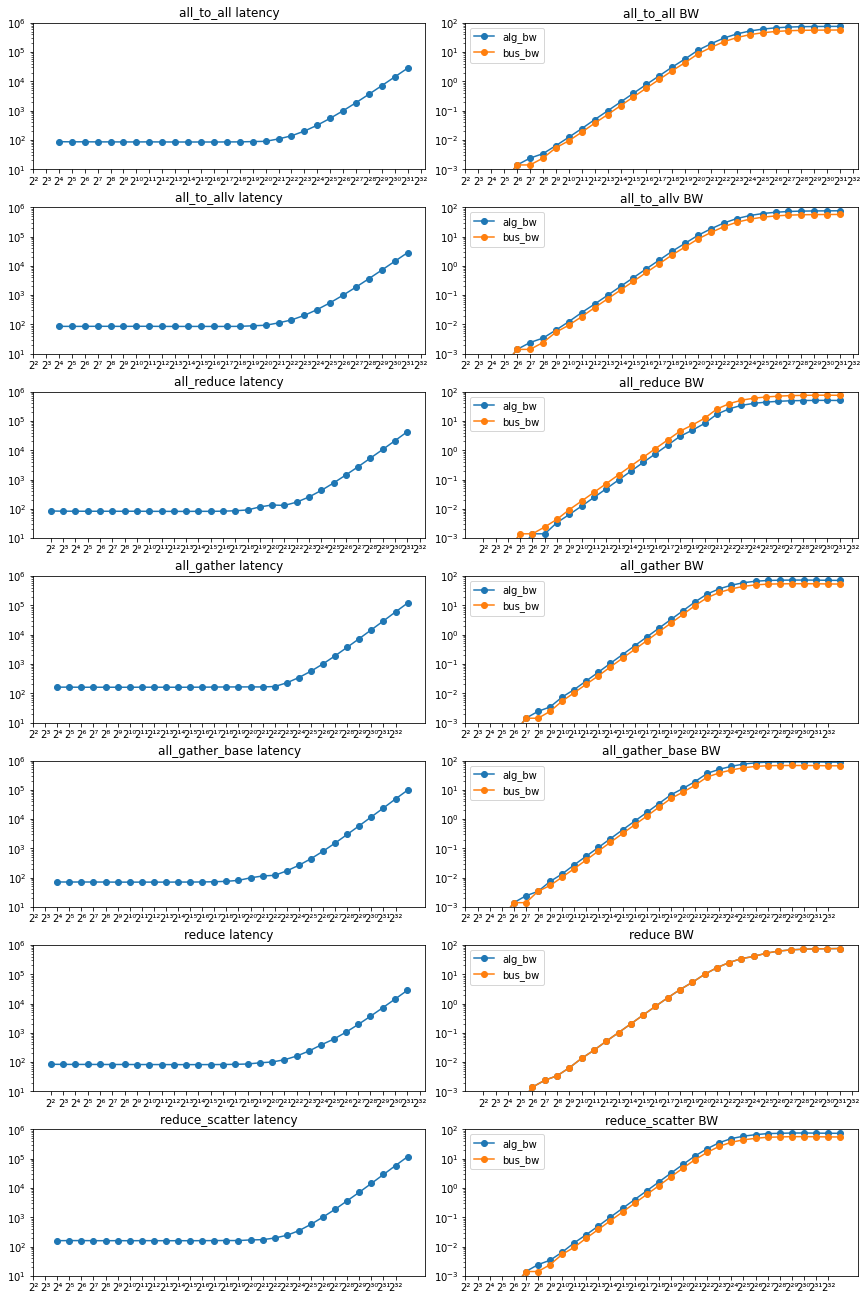

In [70]:
fig = plt.figure(figsize=(12, 18))
for idx, collective in enumerate(collectives):

    ax = fig.add_subplot(num_of_collectives, 2, idx * 2 + 1)
    ax.set_title('{} latency'.format(collective))
    ax.plot(data[collective]['size'], data[collective]['latency'], marker='o')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([1e1, 1e6])
    ax.set_xticks([2**i for i in range(2, 33)])
    ax.set_xticklabels(["2{}".format(str(j).translate(superscript)) for j in range(2, 33)])
    
    ax = fig.add_subplot(num_of_collectives, 2, idx * 2 + 2)
    ax.set_title('{} BW'.format(collective))
    ax.plot(data[collective]['size'], data[collective]['alg_bw'], marker='o')
    ax.plot(data[collective]['size'], data[collective]['bus_bw'], marker='o')
    ax.legend(['alg_bw', 'bus_bw'])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([1e-3, 1e2])
    ax.set_xticks([2**i for i in range(2, 33)])
    ax.set_xticklabels(["2{}".format(str(j).translate(superscript)) for j in range(2, 33)])

fig.tight_layout(pad=0.5)

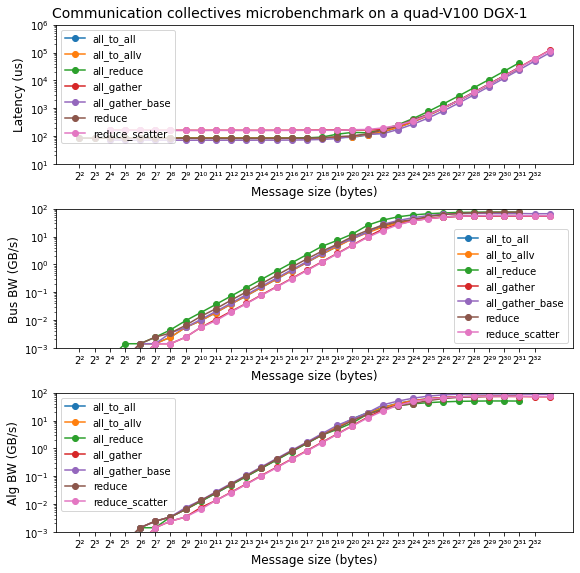

In [71]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)
for idx, collective in enumerate(collectives):
    
    ax1.plot(data[collective]['size'], data[collective]['latency'], marker='o')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_ylim([1e1, 1e6])
    ax1.set_xticks([2**i for i in range(2, 33)])
    ax1.set_xticklabels(["2{}".format(str(j).translate(superscript)) for j in range(2, 33)])
    ax1.set_xlabel("Message size (bytes)", fontsize=12)
    ax1.set_ylabel("Latency (us)", fontsize=12)

    ax2.plot(data[collective]['size'], data[collective]['bus_bw'], marker='o')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_ylim([1e-3, 1e2])
    ax2.set_xticks([2**i for i in range(2, 33)])
    ax2.set_xticklabels(["2{}".format(str(j).translate(superscript)) for j in range(2, 33)])
    ax2.set_xlabel("Message size (bytes)", fontsize=12)
    ax2.set_ylabel("Bus BW (GB/s)", fontsize=12)

    ax3.plot(data[collective]['size'], data[collective]['alg_bw'], marker='o')
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.set_ylim([1e-3, 1e2])
    ax3.set_xticks([2**i for i in range(2, 33)])
    ax3.set_xticklabels(["2{}".format(str(j).translate(superscript)) for j in range(2, 33)])
    ax3.set_xlabel("Message size (bytes)", fontsize=12)
    ax3.set_ylabel("Alg BW (GB/s)", fontsize=12)

ax1.legend(collectives)
ax2.legend(collectives)
ax3.legend(collectives)
fig.suptitle("Communication collectives microbenchmark on a quad-V100 DGX-1", fontsize=14)
fig.tight_layout(pad=0.5)
plt.savefig('../3rdparty/param/train/comms/pt/latency_bw.png', bbox_inches='tight')

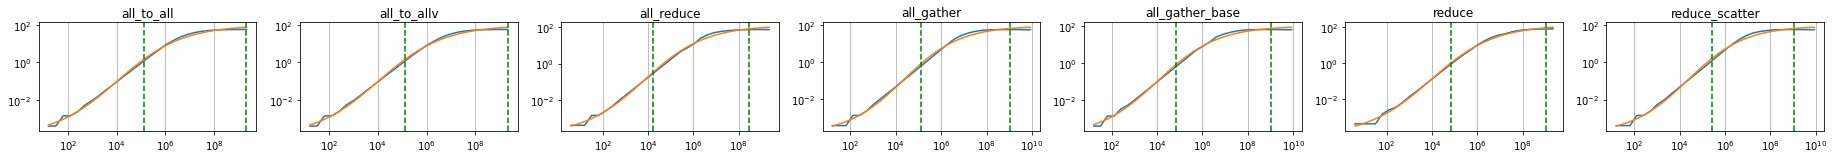

In [72]:
# Get turning points of the bus BW curve for a collective
def get_turning_points(collective_data, ratio_th=0.05):
    num_samples = len(collective_data['bus_bw'])
    max_bw = collective_data['bus_bw'].max()
    ratios = []
    for idx in range(num_samples):
        if idx == 0 or idx == num_samples - 1:
            ratios.append(-1)
            continue
        bw = collective_data['bus_bw'][idx]
        prev_bw = collective_data['bus_bw'][idx-1]
        next_bw = collective_data['bus_bw'][idx+1]
        ratios.append(next_bw * prev_bw / bw / bw)

    # Mark the saturation point with 95% of peak
    for idx in reversed(range(num_samples)):
        if idx == 0 or idx == num_samples - 1:
            continue
        if collective_data['bus_bw'][idx] < (1 - ratio_th) * max_bw:
            saturation_idx = idx
            break

    # Mark the increment point with 3 consecutive flat samples
    count = 0
    for idx in range(num_samples):
        if idx == 0 or idx == num_samples - 1:
            continue
        if abs(ratios[idx] - 1) <= ratio_th:
            count += 1
            if count >= 3:
                increment_idx = idx
                break
        else:
            count = 0

    return increment_idx, saturation_idx

def get_feature(collective_data):
    incr_idx, sats_idx = get_turning_points(collective_data)
    incr_p, sats_p = int(np.log2(collective_data['size'][incr_idx])), int(np.log2(collective_data['size'][sats_idx])) # log sizes of both incr point and sats point
    max_bus_bw = collective_data['bus_bw'].max() # Pick the bw for the 3rd section of the curves
    min_bus_bw = collective_data['bus_bw'][incr_idx] # Pick the bw for the 1st section of the curves
    slope = (np.log10(max_bus_bw / min_bus_bw)) / (sats_p - incr_p)
    overhead = collective_data['latency'][0]
    return (incr_p, sats_p, slope, min_bus_bw, max_bus_bw, overhead)

def sigmoid(x, L, x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return y

def fit_sigmoid_bw_predictor(collective_data):
    xdata = np.log2(collective_data['size'])
    ydata = np.log10(collective_data['bus_bw'])
    p0 = [ydata.max(), 
            np.median(xdata),
            1,
            ydata.min()] # this is an mandatory initial guess
    popt, _ = curve_fit(sigmoid, xdata, ydata, p0, method='dogbox')
    return popt

def get_linear_bw(s, s0, k, b):
    return 10 ** ((s - s0) * k) * b

def get_sigmoid_bw(s, sigmoid_param):
    return 10 ** sigmoid(s, *sigmoid_param)

def predict_linear(size, f, incr_p, sats_p, slope, min_bw, max_bw, overhead):
    log_size = np.log2(size)
    if log_size <= incr_p:
        return overhead
    elif log_size >= sats_p:
        return size / max_bw * f(num_gpus) / 1e3 + overhead
    else:
        bw = get_linear_bw(log_size, incr_p, slope, min_bw)
        return size / bw * f(num_gpus) / 1e3 + overhead

def predict_sigmoid(size, sigmoid_param, f, incr_p, sats_p, slope, min_bw, max_bw, overhead):
    log_size = np.log2(size)
    if log_size <= incr_p:
        return overhead
    elif log_size >= sats_p:
        return size / max_bw * f(num_gpus) / 1e3 + overhead
    else:
        bw = get_sigmoid_bw(log_size, sigmoid_param)
        return size / bw * f(num_gpus) / 1e3

# Get slopes of for the 2nd section of the curves
stats = {}
sigmoid_params = {}
fig, axs = plt.subplots(1, len(collectives), figsize=(32, 2))
for idx, collective in enumerate(collectives):
    stats[collective] = get_feature(data[collective])
    popt = fit_sigmoid_bw_predictor(data[collective])
    sigmoid_params[collective] = popt
    axs[idx].plot(data[collective]['size'], data[collective]['bus_bw'])
    axs[idx].plot(data[collective]['size'], get_sigmoid_bw(np.log2(data[collective]['size']), popt))
    axs[idx].axvline(data[collective]['size'][stats[collective][0]], linestyle='--', color='green')
    axs[idx].axvline(data[collective]['size'][stats[collective][1]], linestyle='--', color='green')
    axs[idx].set_xscale('log')
    axs[idx].set_yscale('log')
    axs[idx].grid(axis='x')
    axs[idx].set_title(collective)

    # # Prediction
    # print("----- {} -----".format(collective))
    # for idx, size in enumerate(data[collective]['size']):
    #     f_mul_factor = mul_factor_funcs[collective]
    #     f_sigmoid_bw = sigmoid_params[collective]
    #     print("{:.2f}, {:.2f}, {:.2f}".format(
    #         data[collective]['latency'][idx],
    #         predict_linear(size, f_mul_factor, *stats[collective]),
    #         predict_sigmoid(size, f_sigmoid_bw, f_mul_factor, *stats[collective])
    #     ))

Current limitations:
- Prediction error is high near the two turning points. Probably need another way to fit the curve. Updates: sigmoid can fit the corners well.
- Is there a way to directly get the min/max BW from device connection configuration w/o benchmarking? Can the bus BW be derived from the algo BW which seems to follow a pattern (50, 75, 87.5 GB/s)?

e.g. 4 GPUs, all_to_all, each GPU sends 1/4 elements to each of the other GPUs
- --b/--e (in bytes per rank): 16, 32, 64...
- allSizes (in bytes per rank): 16, 32, 64...
- memSize / size (B) in printed results (in bytes per rank): 16, 32, 64...
- num-elements in printed results (in elements COMMUNICATED per rank-pair): 1, 2, 4...

commsParams.element_size: 4 (float)
comm_fn: backendFuncs.collectiveFunc[commsParams.collective]
comms.py comm op line 1202 calls runColl line 258
--z/commsParamsHolderBase's blockingFlag/~asyncOp 1: non-blocking, 0: blocking
gatherBenchTime line 767: gather bench time stored in tensors on each device to a list of tensors on rank 0.

param pytorch_dist_backend: all_to_all line 163 calls dist.all_to_all_single line 170, wait function called at line 389
dlrm extend_distributed: alltoall line 597 calls All2All_Req line 404 calls dist.all_to_all_single line 429 (list of local tensors concatenated and flatten to 1D)

e.g. batched_emb
dist.all_to_all_single: input_split_sizes (how tables are distributed to devices, e.g. 13 tables and [2,3,3,5] on 4 GPUs), output_split_sizes (how batches are distributed to devices; set to None for equal distribution, e.g. batch size 2048 -> 512 per GPU)
common case: input_split_sizes not None, output_split_sizes None

- reduce scatter: memSize measures the INPUT size in bytes per rank (equal to total OUTPUT size on all devices)
- all gather: memSize measures the OUTPUT size in bytes per rank (equal to total INPUT size on all devices)

In [73]:
filename = '../3rdparty/param/train/comms/pt/bench_results/general_all_to_allv_4.txt'
header_found = False
general_data = {
    'btd': [],
    'size': [],
    'latency': [],
    'alg_bw': [],
    'bus_bw': []
}
with open(filename, 'r') as f:
    lines = f.readlines()
    for line in lines:
        if re.search('COMMS-RES', line):
            if not header_found:
                header_found = True
                continue
            general_data['btd'].append(line.split('\t')[3].lstrip('\t'))
            general_data['size'].append(int(line.split('\t')[2].lstrip('\t')))
            general_data['latency'].append(sum([float(s) for s in line.split('\t')[6].lstrip('\t').split('-')]) / num_gpus)
            general_data['alg_bw'].append(sum([float(s) for s in line.split('\t')[4].lstrip('\t').split('-')]) / num_gpus + epsilon)
            general_data['bus_bw'].append(sum([float(s) for s in line.split('\t')[5].lstrip('\t').rstrip('\n').split('-')]) / num_gpus + epsilon)
    general_data['size'] = np.array(general_data['size'])
    general_data['latency'] = np.array(general_data['latency'])
    general_data['alg_bw'] = np.array(general_data['alg_bw'])
    general_data['bus_bw'] = np.array(general_data['bus_bw'])
df = pd.DataFrame(general_data)
df.head()

,btd,size,latency,alg_bw,bus_bw
0,"256,1-1-1-1,32",32768,90.829700,0.361175,0.270975
1,"256,1-1-1-1,64",65536,90.563850,0.724075,0.543150
2,"256,1-1-1-1,128",131072,90.493375,1.448925,1.086800
3,"256,1-1-1-1,256",262144,91.376175,2.872000,2.154100
4,"256,1-1-1-2,32",40960,91.007550,0.450950,0.338300


In [74]:
s = stats['all_to_allv']
f_mul_factor = mul_factor_funcs["all_to_allv"]
sigmoid_param = sigmoid_params["all_to_allv"]
x = df['size']
y = x.apply(predict_sigmoid, args=(sigmoid_param, f_mul_factor, *s))

In [75]:
error = abs_err(y, df['latency'])
print("All to allv: GMAE: {:.2f}%, mean: {:.2f}%, std: {:.2f}%".format(gmae(error) * 100.0, error.mean() * 100.0, error.std() * 100.0))
_ = histogram(error)

All to allv: GMAE: 7.00%, mean: 10.12%, std: 6.88%
0% - 5%: 28.31%
5% - 10%: 26.10%
10% - 15%: 21.18%
15% - 20%: 13.75%
20% - 25%: 8.60%
25% - 30%: 1.91%
30% - 40%: 0.15%
40% - 50%: 0.01%
50% - 60%: 0.00%
60% - 80%: 0.00%
80% - 100%: 0.00%
100% - 150%: 0.00%
150% - 200%: 0.00%
200% - 300%: 0.00%
300% - 400%: 0.00%


(13, 27, 0.20586519633695022, 0.0744, 56.7134, 85.6)


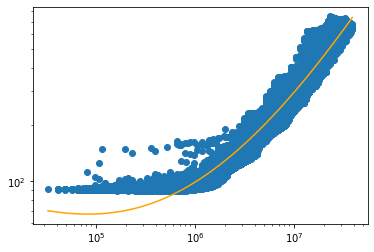

In [76]:
sorted_df = df.sort_values(['size'], ascending=[1])
fig = plt.figure()
ax = plt.gca()
ax.scatter(sorted_df['size'], sorted_df['latency'])
ax.plot(sorted_df['size'], sorted_df['size'].apply(predict_sigmoid, args=(sigmoid_param, f_mul_factor, *s)), color='orange')
ax.set_yscale('log')
ax.set_xscale('log')

In [77]:
# Exploration
def get_adjusted_size(s, num_gpus, max_type):
    splitted = s.split(',')
    B = int(splitted[0]) // num_gpus
    D = int(splitted[2])
    tables = [int(t) for t in splitted[1].split('-')]
    if max_type == "max_of_max":
        T_max = max([max(sum(tables) - t, t * (num_gpus-1)) for t in tables])
    elif max_type == "max_of_sum":
        T_max = max([(sum(tables) - t + t * (num_gpus-1)) for t in tables])
    else:
        raise Exception("Unrecognized max_type")
    return B * T_max * D * 4 # float32

for max_type in ['max_of_max', 'max_of_sum']:
    adjusted_size = df['btd'].apply(get_adjusted_size, args=(num_gpus, max_type))
    y1 = adjusted_size.apply(predict_sigmoid, args=(sigmoid_param, f_mul_factor, *s))
    error1 = abs_err(y1, df['latency'])
    print("All to allv ({}): GMAE: {:.2f}%, mean: {:.2f}%, std: {:.2f}%".format(max_type, gmae(error1) * 100.0, error1.mean() * 100.0, error1.std() * 100.0))
    _ = histogram(error1)

All to allv (max_of_max): GMAE: 10.17%, mean: 12.95%, std: 6.61%
0% - 5%: 15.21%
5% - 10%: 16.98%
10% - 15%: 28.32%
15% - 20%: 23.34%
20% - 25%: 13.99%
25% - 30%: 1.95%
30% - 40%: 0.21%
40% - 50%: 0.01%
50% - 60%: 0.00%
60% - 80%: 0.00%
80% - 100%: 0.00%
100% - 150%: 0.00%
150% - 200%: 0.00%
200% - 300%: 0.00%
300% - 400%: 0.00%
All to allv (max_of_sum): GMAE: 25.92%, mean: 33.42%, std: 16.50%
0% - 5%: 6.75%
5% - 10%: 5.89%
10% - 15%: 5.68%
15% - 20%: 7.97%
20% - 25%: 4.99%
25% - 30%: 3.99%
30% - 40%: 23.12%
40% - 50%: 26.60%
50% - 60%: 12.49%
60% - 80%: 2.53%
80% - 100%: 0.00%
100% - 150%: 0.00%
150% - 200%: 0.00%
200% - 300%: 0.00%
300% - 400%: 0.00%
